# Building a model

In this notebook I will test various machine learning models to find one that gives the best results in predicting the churn.

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import srs

from sklearn import metrics

In [2]:
import seaborn as sns

sns.set()

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data

In [4]:
dataset = pd.read_csv('../data/transformed.csv', index_col='customerID')

Description of the features:
* Gender: The customer’s gender: Male, Female
* Senior Citizen: Indicates if the customer is 65 or older: Yes, No
* Partner: Indicates if the customer is a partner: Yes, No
* Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
* Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
* Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
* Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
* Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
* Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
* Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
* Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service
* Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service
* Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year
* Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
* Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
* Tenure Buckets: Indicates the range in which the customer's tenure value is, it is denoted in months: 0-20, 21-50, 50+
* Monthly Charges Buckets: Indicates a range in which the customer’s current total monthly charge is for all their services from the company: 0-40, 41-60, 60+
* Multiple Lines Buckets: Indicates if the customer subscribes to multiple telephone lines with the company: Yes; either has one line or not at all: Other
* Num Internet Services: Indicates the total number of additional internet services the customer has: 0 - 6
* Churn: Indicates if the customer have churned: Yes, No

In [5]:
dataset.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureBuckets,MonthlyChargesBuckets,MultipleLinesBuckets,NumInternetlServices,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0-20,0-40,Other,1,No
5575-GNVDE,Male,No,No,No,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,21-50,41-60,Other,2,No
3668-QPYBK,Male,No,No,No,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0-20,41-60,Other,2,Yes
7795-CFOCW,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),21-50,41-60,Other,3,No
9237-HQITU,Female,No,No,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0-20,60+,Other,0,Yes


In [6]:
dataset.shape

(7043, 20)

In [7]:
data = dataset.sample(frac=0.9, random_state=45)
data_validation = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_validation.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Final Validation ' + str(data_validation.shape))

Data for Modeling: (6339, 20)
Unseen Data For Final Validation (704, 20)


### Building a model

To quickly iterate through various models i will use the [PyCaret](https://pycaret.org) library. It is an open-source, low-code machine learning library in Python that automates machine learning workflows.

The kind of a model that suits our case is a binary classification model.

In [8]:
from pycaret.classification import *

Initialize the training environment and create the transformation pipeline.

In [9]:
setup(
    data, 
    target='Churn',
    n_jobs=5,
    fold=5,
    train_size=0.8,
    silent=True,
    numeric_features=['NumInternetlServices'],
    normalize=True,
    fix_imbalance=True,
);

,Description,Value
0,session_id,4386
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(6339, 20)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


Compare various models.

In [10]:
compare_models(include=['lr', 'svm', 'ridge', 'knn', 'dt'], sort='f1');

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7371,0.0000,0.7931,0.4981,0.6117,0.4283,0.4551,0.0200
lr,Logistic Regression,0.7393,0.8359,0.7810,0.5008,0.6100,0.4281,0.4521,0.4200
svm,SVM - Linear Kernel,0.7450,0.0000,0.7478,0.5168,0.6045,0.4284,0.4508,0.0260
knn,K Neighbors Classifier,0.6863,0.7450,0.7100,0.4380,0.5415,0.3229,0.3450,0.0840
dt,Decision Tree Classifier,0.7160,0.6648,0.5099,0.4605,0.4835,0.2885,0.2895,0.0240


### Tune the models

**Logisitc regression**

In [11]:
lr = create_model('lr');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7606,0.8353,0.7887,0.5278,0.6324,0.4650,0.4857
1,0.7337,0.8198,0.7321,0.4936,0.5897,0.4034,0.4206
2,0.7367,0.8573,0.7962,0.4976,0.6125,0.4287,0.4559
3,0.7337,0.8375,0.7925,0.4941,0.6087,0.4229,0.4500
4,0.7318,0.8299,0.7955,0.4907,0.6069,0.4202,0.4485
Mean,0.7393,0.8359,0.7810,0.5008,0.6100,0.4281,0.4521
SD,0.0108,0.0123,0.0246,0.0137,0.0136,0.0203,0.0207


In [12]:
custom_grid = {
    'fit_intercept': [True],
    'solver': ['saga'],
    'penalty': ['elasticnet'],
    'C': np.logspace(0.0001, 4, num=50) / 100,
    'class_weight': ['balanced'],
    'dual': [False],
    'max_iter': [1000],
    'l1_ratio': [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
}

In [13]:
%time tuned_lr = tune_model(lr, n_iter=100, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7626,0.8364,0.7887,0.5305,0.6343,0.4683,0.4885
1,0.7347,0.8218,0.7321,0.4949,0.5906,0.4050,0.4220
2,0.7387,0.8562,0.7849,0.5000,0.6109,0.4283,0.4531
3,0.7426,0.8372,0.8038,0.5047,0.6201,0.4404,0.4677
4,0.7347,0.8299,0.8030,0.4942,0.6118,0.4272,0.4563
Mean,0.7427,0.8363,0.7825,0.5049,0.6135,0.4339,0.4575
SD,0.0104,0.0114,0.0263,0.0134,0.0142,0.0207,0.0217


CPU times: user 2.34 s, sys: 270 ms, total: 2.61 s
Wall time: 1min 21s


In [14]:
tuned_lr

LogisticRegression(C=0.11515901968065019, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.9,
                   max_iter=1000, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=4386, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [16]:
srs.evaluate_model(tuned_lr)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.765 |    0.825 |       0.557 | 0.665 |
+---------------+------------+----------+-------------+-------+


**Ridge classifier**

In [17]:
ridge = create_model('ridge');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7527,0.0000,0.7925,0.5172,0.6259,0.4532,0.4762
1,0.7288,0.0000,0.7434,0.4876,0.5889,0.3993,0.4191
2,0.7396,0.0000,0.8113,0.5012,0.6196,0.4380,0.4674
3,0.7396,0.0000,0.8038,0.5012,0.6174,0.4357,0.4637
4,0.7249,0.0000,0.8144,0.4831,0.6065,0.4154,0.4490
Mean,0.7371,0.0000,0.7931,0.4981,0.6117,0.4283,0.4551
SD,0.0098,0.0000,0.0260,0.0120,0.0130,0.0188,0.0200


In [24]:
custom_grid = {
    'fit_intercept': [True],
    'max_iter': [1000],
    'normalize': [True, False],
    'class_weight': ['balanced'],
    'solver': ['auto'],
    'alpha': np.logspace(0.0001, 4, num=50) / 1000,
}

In [25]:
%time tuned_ridge = tune_model(ridge, n_iter=200, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7576,0.0000,0.7887,0.5238,0.6295,0.4601,0.4814
1,0.7288,0.0000,0.7472,0.4877,0.5902,0.4006,0.4210
2,0.7426,0.0000,0.8038,0.5047,0.6201,0.4404,0.4677
3,0.7426,0.0000,0.8038,0.5047,0.6201,0.4404,0.4677
4,0.7288,0.0000,0.8182,0.4876,0.6110,0.4227,0.4561
Mean,0.7401,0.0000,0.7923,0.5017,0.6142,0.4328,0.4588
SD,0.0107,0.0000,0.0244,0.0134,0.0134,0.0200,0.0205


CPU times: user 1.7 s, sys: 404 ms, total: 2.1 s
Wall time: 7.72 s


In [26]:
tuned_ridge

RidgeClassifier(alpha=0.07544041722863098, class_weight='balanced', copy_X=True,
                fit_intercept=True, max_iter=1000, normalize=True,
                random_state=4386, solver='auto', tol=0.001)

In [34]:
srs.evaluate_model(tuned_ridge)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.763 |    0.833 |       0.554 | 0.665 |
+---------------+------------+----------+-------------+-------+


**SVM - with linear kernel**

In [28]:
svm = create_model('svm');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7606,0.0000,0.7434,0.5296,0.6185,0.4512,0.4649
1,0.7722,0.0000,0.5811,0.5620,0.5714,0.4163,0.4165
2,0.7525,0.0000,0.7774,0.5176,0.6214,0.4483,0.4688
3,0.7633,0.0000,0.7396,0.5341,0.6203,0.4548,0.4675
4,0.6765,0.0000,0.8977,0.4405,0.5910,0.3715,0.4365
Mean,0.7450,0.0000,0.7478,0.5168,0.6045,0.4284,0.4508
SD,0.0348,0.0000,0.1012,0.0408,0.0200,0.0316,0.0209


In [30]:
custom_grid = {
    'loss': ['hinge'], # This value is required for the SVM
    'penalty': ['elasticnet'],
    'alpha': np.logspace(0.0001, 4, num=50) / 100000,
    'l1_ratio': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
    'fit_intercept': [True],
    'max_iter': [500],
    'learning_rate': ['optimal'],
    'class_weight': ['balanced'],
}

In [31]:
%time tuned_svm = tune_model(svm, n_iter=500, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7813,0.0000,0.7736,0.5586,0.6487,0.4959,0.5097
1,0.7357,0.0000,0.7623,0.4963,0.6012,0.4165,0.4379
2,0.7229,0.0000,0.8679,0.4832,0.6208,0.4291,0.4750
3,0.7919,0.0000,0.7019,0.5849,0.6381,0.4937,0.4978
4,0.6647,0.0000,0.8864,0.4301,0.5792,0.3521,0.4163
Mean,0.7393,0.0000,0.7984,0.5106,0.6176,0.4374,0.4673
SD,0.0456,0.0000,0.0690,0.0552,0.0251,0.0536,0.0354


CPU times: user 8.14 s, sys: 1.03 s, total: 9.18 s
Wall time: 48.1 s


In [32]:
tuned_svm

SGDClassifier(alpha=7.907455101892067e-05, average=False,
              class_weight='balanced', early_stopping=False, epsilon=0.1,
              eta0=0.001, fit_intercept=True, l1_ratio=0.95,
              learning_rate='optimal', loss='hinge', max_iter=500,
              n_iter_no_change=5, n_jobs=5, penalty='elasticnet', power_t=0.5,
              random_state=4386, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
srs.evaluate_model(tuned_svm)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.694 |    0.914 |       0.479 | 0.628 |
+---------------+------------+----------+-------------+-------+


**KNN**

In [35]:
knn = create_model('knn');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6877,0.7548,0.7132,0.4395,0.5439,0.3262,0.3483
1,0.6795,0.7240,0.6566,0.4265,0.5171,0.2931,0.3084
2,0.7071,0.7625,0.7132,0.4610,0.5600,0.3553,0.3744
3,0.6726,0.7361,0.7019,0.4237,0.5284,0.3004,0.3229
4,0.6844,0.7475,0.7652,0.4391,0.5580,0.3395,0.3712
Mean,0.6863,0.7450,0.7100,0.4380,0.5415,0.3229,0.3450
SD,0.0116,0.0136,0.0346,0.0132,0.0167,0.0234,0.0260


In [36]:
custom_grid = {
    'n_neighbors': np.arange(1, 21, 1),
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [0, 1, 2]
}

In [39]:
%time tuned_knn = tune_model(knn, n_iter=500, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7448,0.8099,0.7585,0.5076,0.6082,0.4298,0.4489
1,0.7308,0.7978,0.6906,0.4893,0.5728,0.3845,0.3966
2,0.7357,0.8205,0.7358,0.4962,0.5927,0.4078,0.4252
3,0.7268,0.8090,0.7660,0.4856,0.5944,0.4037,0.4275
4,0.7258,0.8021,0.7500,0.4829,0.5875,0.3963,0.4179
Mean,0.7328,0.8078,0.7402,0.4923,0.5911,0.4044,0.4232
SD,0.0069,0.0078,0.0268,0.0088,0.0114,0.0150,0.0168


CPU times: user 5.69 s, sys: 700 ms, total: 6.39 s
Wall time: 1min 14s


In [40]:
tuned_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=5, n_neighbors=20, p=1,
                     weights='uniform')

In [41]:
srs.evaluate_model(tuned_knn)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.766 |    0.774 |       0.563 | 0.652 |
+---------------+------------+----------+-------------+-------+


**Decision tree**

In [42]:
dt = create_model('dt');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7153,0.6498,0.4642,0.4556,0.4598,0.2665,0.2665
1,0.7170,0.6532,0.4830,0.4604,0.4715,0.2783,0.2785
2,0.7081,0.6642,0.5208,0.4495,0.4825,0.2807,0.2822
3,0.7081,0.6592,0.5283,0.4502,0.4861,0.2841,0.2858
4,0.7318,0.6975,0.5530,0.4867,0.5177,0.3330,0.3343
Mean,0.7160,0.6648,0.5099,0.4605,0.4835,0.2885,0.2895
SD,0.0087,0.0171,0.0320,0.0137,0.0194,0.0230,0.0233


In [44]:
custom_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': np.arange(2, 11, 1),
    'max_features': ['log2'],
    'class_weight': ['balanced'],
    'ccp_alpha': np.logspace(0.0001, 4, num=50)[:25] / 10000
}

In [45]:
%time tuned_dt = tune_model(dt, n_iter=500, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7773,0.8261,0.7245,0.5565,0.6295,0.4742,0.4827
1,0.7801,0.8036,0.6415,0.5705,0.6039,0.4524,0.4539
2,0.7436,0.8174,0.7660,0.5062,0.6096,0.4303,0.4508
3,0.7564,0.8103,0.7434,0.5239,0.6147,0.4443,0.4588
4,0.7594,0.8055,0.7045,0.5284,0.6039,0.4361,0.4454
Mean,0.7634,0.8126,0.7160,0.5371,0.6123,0.4475,0.4583
SD,0.0136,0.0082,0.0424,0.0232,0.0095,0.0153,0.0129


CPU times: user 4.62 s, sys: 502 ms, total: 5.12 s
Wall time: 26 s


In [46]:
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.002442420340775528, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=4386,
                       splitter='best')

In [47]:
srs.evaluate_model(tuned_dt)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.763 |    0.769 |        0.56 | 0.648 |
+---------------+------------+----------+-------------+-------+


### Finalize a model

In [50]:
final_lr = finalize_model(tuned_lr)

In [51]:
final_lr

LogisticRegression(C=0.11515901968065019, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.9,
                   max_iter=1000, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=4386, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [52]:
srs.evaluate_model(final_lr, data=data_validation)

+---------------+------------+----------+-------------+------+
|               |   Accuracy |   Recall |   Precision |   F1 |
+===============+============+==========+=============+======+
| Model Summary |      0.744 |    0.726 |       0.511 |  0.6 |
+---------------+------------+----------+-------------+------+


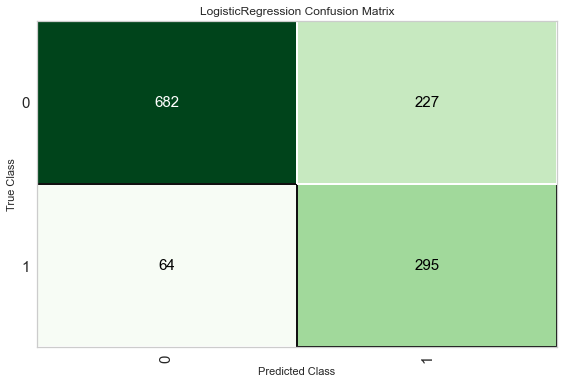

In [53]:
plot_model(final_lr, plot = 'confusion_matrix', save=True)
plot_model(final_lr, plot = 'confusion_matrix', save=False)

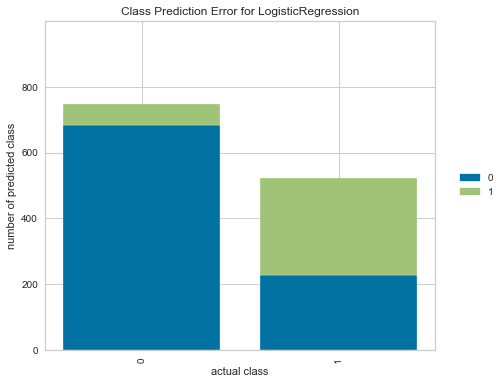

In [54]:
plot_model(final_lr, plot = 'error', save=True)
plot_model(final_lr, plot = 'error', save=False)

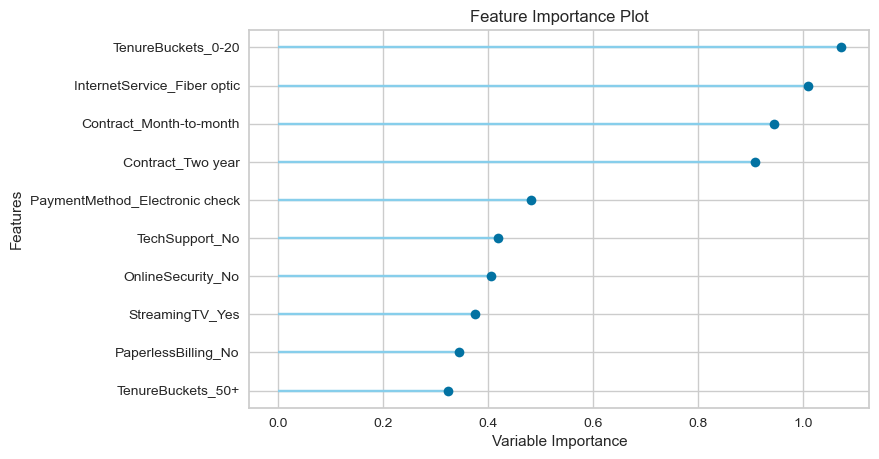

In [56]:
plot_model(final_lr, plot = 'feature', save=True)
plot_model(final_lr, plot = 'feature', save=False)

Save the model.

In [55]:
save_model(final_lr, 'lr_pipeline_05112021', model_only=False)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['NumInternetlServices'],
                                       target='Churn', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numeri...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=0.11515901968065019,
                                     class_weight='balanced', dual

In [ ]:
# final_lr = load_model('../model/lr_pipeline_31102021')